Nous allons, dans ce notebook, réaliser un modèle de base que nous comparerons avec un modèle plus avancé.

# Import des librairies

In [1]:
# Import libraries
import pandas as pd
import numpy as np

from textblob import TextBlob
from afinn import Afinn

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
%matplotlib inline

# Import de la data

In [2]:
# Import pre-processed data
df = pd.read_csv('data/df_preprocessing_final.csv')

# Suppression des colonnes inutiles
df = df.drop(columns=['user', 'id', 'nombre_mot'])

df.head()

,sentiment,tweet,tweet_traite,tweet_stemm,tweet_lemm
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",user url that is bummer you should got david c...,user url that is bummer you should got david c...,user url that be bummer you should got david c...
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,is upset that he cannot updat hi facebook by t...,be upset that he can not update his facebook b...
2,0,@Kenichan I dived many times for the ball. Man...,user dived many times for the ball managed to ...,user dive mani time for the ball manag to save...,user dive many time for the ball manage to sav...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,my whole bodi feel itchi and like it is on fire,my whole body feel itchy and like it be on fire
4,0,"@nationwideclass no, it's not behaving at all....",user no it is not behaving at all am mad why a...,user no it is not behav at all am mad whi am h...,user no it be not behave at all be mad why be ...


In [3]:
# Nous allons récuperer un sample de notre dataframe
row = 500

# Permet de garder un équilibrage de la target contrairement à un
# .sample() basique
df_sample = df.groupby('sentiment').apply(
    lambda x: x.sample(n=row, random_state=42))
df_sample.reset_index(drop=True, inplace=True)

In [4]:
print(df_sample.shape)
print(df_sample.sentiment.value_counts())
df_sample.head()

(1000, 5)
0    500
1    500
Name: sentiment, dtype: int64


,sentiment,tweet,tweet_traite,tweet_stemm,tweet_lemm
0,0,"@LeahMul awh, thats not good, get better soon!",user awh that is not good get better soon,user awh that is not good get better soon,user awh that be not good get well soon
1,0,I need a job,need job,need job,need job
2,0,i am pretty sure i have swine flu woohooo one...,am pretty sure have swine flu woohooo one tes...,am pretti sure have swine flu woohooo one tes...,be pretty sure have swine flu woohooo one tes...
3,0,GLG will never EVER be the same,glg will never ever be the same,glg will never ever be the same,glg will never ever be the same
4,0,Enjoying my last days w/ my 1 year old Where ...,enjoying my last days my year old where does t...,enjoy my last day my year old where doe the fr...,enjoy my last day my year old where do the frk...


Un rappel du nettoyage effectué sur chaque tweet.

- **tweet** : Tweets bruts
- **tweet_traite** : Nettoyage général (contraction, abrégé, ponctuation, etc.)
- **tweet_stemm** : Tweets traités qui ont été racisés
- **tweet_lemm**: Tweets traités qui ont été lemmatisés

Exportons notre dataframe samplée pour avoir à peu près les mêmes résultats lors de notre développement.

In [5]:
df_sample.to_csv('data/df_model_base.csv', index=False)
# df_sample = pd.read_csv('data/df_model_base.csv')

# Analyse sentiment

## Modèle pré-entrainé

### TextBlob

**TextBlob** est un module NLP sur Python utilisé pour **l’analyse de sentiment**. La fonction de TextBlob qui nous intéresse permet pour un texte **donné de déterminer le ton du texte et le sentiment de l'utilisateur**.

Faisons un premier test avec un sentiment négatif inventé.

In [6]:
tweet_negatif = "This restaurant is very, very bad and I think I will never go back there"
tweet_positif = 'This restaurant is really amazing'
print(TextBlob(tweet_negatif).sentiment)
print(TextBlob(tweet_positif).sentiment)

Sentiment(polarity=-0.4549999999999999, subjectivity=0.43333333333333335)
Sentiment(polarity=0.6000000000000001, subjectivity=0.9)


**La polarité** va d'une déclaration **négative (-1)** à une déclaration **positive (1)**.

**La subjectivité**, indique dans quelle mesure la phrase est **factuelle (0)** ou empreinte **une opinion (1)**.

TextBlob a bien détecté le sentiment du tweet, nous passerons sur sa subjectivité qui n'est pas le sujet de ce projet.

Nous allons maintenant utiliser Textblob pour chaque tweet (traités, lemm et stemm).

Puis nous pourrons ensuite comparer la qualité de la prédiction en fonction du type de tweet.

In [7]:
df_sample_txtblob = df_sample.copy()

In [8]:
# Cette fonction applique textblob sur chaque tweet pour ensuite
# remplacé les valeurs supérieures à 0 par 1 et inférieures à 0 par 0
def prediction_textblob(df, tweet_type_colonne, prediction_type):
    df[prediction_type] = df[tweet_type_colonne].apply(
        lambda tweet: TextBlob(tweet).sentiment[0])

    df.loc[df[prediction_type] > 0, prediction_type] = 1
    df.loc[df[prediction_type] < 0, prediction_type] = 0

    df[prediction_type] = df[prediction_type].astype(int)

    return df[prediction_type]

In [9]:
df_sample_txtblob["TextBlob+brute"] = prediction_textblob(
    df_sample_txtblob, "tweet", "pred_brute_txtblob")
df_sample_txtblob["TextBlob+traite"] = prediction_textblob(
    df_sample_txtblob, "tweet_traite", "pred_traite_txtblob")
df_sample_txtblob["TextBlob+stemm"] = prediction_textblob(
    df_sample_txtblob, "tweet_stemm", "pred_stemm_txtblob")
df_sample_txtblob["TextBlob+lemm"] = prediction_textblob(
    df_sample_txtblob, "tweet_lemm", "pred_lemm_txtblob")

In [10]:
df_sample_txtblob

,sentiment,tweet,tweet_traite,tweet_stemm,tweet_lemm,pred_brute_txtblob,TextBlob+brute,pred_traite_txtblob,TextBlob+traite,pred_stemm_txtblob,TextBlob+stemm,pred_lemm_txtblob,TextBlob+lemm
0,0,"@LeahMul awh, thats not good, get better soon!",user awh that is not good get better soon,user awh that is not good get better soon,user awh that be not good get well soon,1,1,1,1,1,1,0,0
1,0,I need a job,need job,need job,need job,0,0,0,0,0,0,0,0
2,0,i am pretty sure i have swine flu woohooo one...,am pretty sure have swine flu woohooo one tes...,am pretti sure have swine flu woohooo one tes...,be pretty sure have swine flu woohooo one tes...,1,1,1,1,1,1,1,1
3,0,GLG will never EVER be the same,glg will never ever be the same,glg will never ever be the same,glg will never ever be the same,0,0,0,0,0,0,0,0
4,0,Enjoying my last days w/ my 1 year old Where ...,enjoying my last days my year old where does t...,enjoy my last day my year old where doe the fr...,enjoy my last day my year old where do the frk...,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,"@movinmeat Yes, but I think you may be in town...",user yes but think you may be in town at the s...,user ye but think you may be in town at the sa...,user yes but think you may be in town at the s...,0,0,0,0,0,0,0,0
996,1,@michxxblc oh..i have tons of pics of uk too! ...,user oh have tons of pics of uk too dublin and...,user oh have ton of pic of uk too dublin and b...,user oh have ton of pic of uk too dublin and b...,0,0,0,0,0,0,0,0
997,1,@Oprah i'm watching your show right now,user am watching your show right now,user am watch your show right now,user be watch your show right now,1,1,1,1,1,1,1,1
998,1,@NickkMuch lol! Who you babysittin? x,user who you babysittin,user who you babysittin,user who you babysittin,1,1,0,0,0,0,0,0


#### Matrice de confusion

Voyons maintenant la matrice de confusion pour chaque colonne, nous pourrons alors déterminer quel type de tweet TextBlob prédit le plus correctement le sentiment.

Nous utilisons la métrique **f1 score** qui permet de prendre en compte les faux positifs et faux négatifs dans le calcul du score.

In [11]:
liste_prediction_type_txtblob = [
    "TextBlob+brute", "TextBlob+traite", "TextBlob+stemm", "TextBlob+lemm"
]

In [12]:
def matrice_confusion(df, prediction_type):
    y_true = list(df["sentiment"])
    y_pred = list(df[prediction_type])

    cf_matrix = confusion_matrix(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)
    print("Score f1 " + str(score_f1))
    print("Score acc " + str(score_acc))
    # Rends les valeurs de la matrice sous forme de pourcentage
    ax = sns.heatmap(cf_matrix / np.sum(cf_matrix),
                     annot=True,
                     fmt='.2%',
                     cmap='Blues')

    ax.set_title(prediction_type)
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Target')

    ax.xaxis.set_ticklabels(['negatif', 'positif'])
    ax.yaxis.set_ticklabels(['negatif', 'positif'])

    plt.show()
    return score_f1, score_acc

Score f1 0.6023329798515377
Score acc 0.625


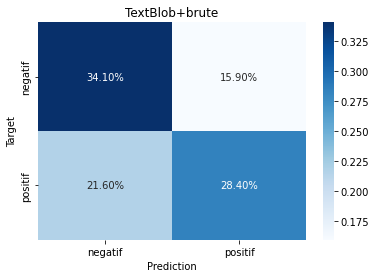

Score f1 0.6023329798515377
Score acc 0.625


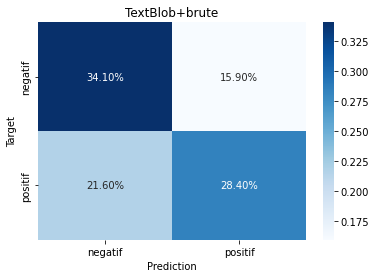

Score f1 0.5844155844155845
Score acc 0.616


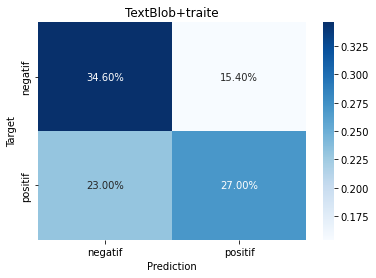

Score f1 0.5844155844155845
Score acc 0.616


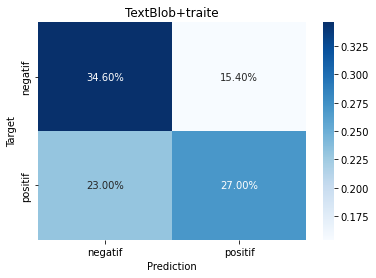

Score f1 0.496437054631829
Score acc 0.576


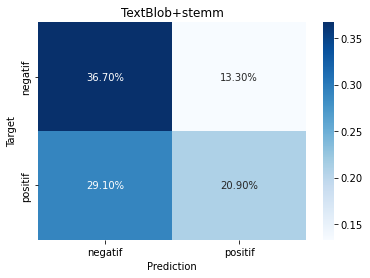

Score f1 0.496437054631829
Score acc 0.576


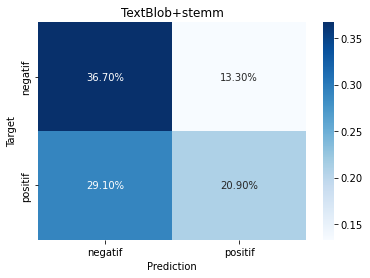

Score f1 0.5701754385964912
Score acc 0.608


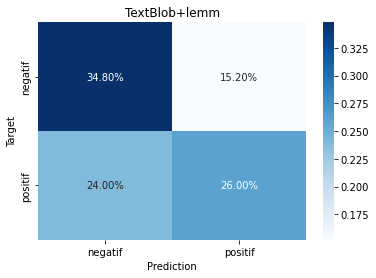

Score f1 0.5701754385964912
Score acc 0.608


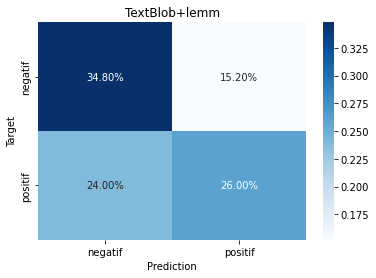

In [13]:
dict_score_txtblob = {}
for i in liste_prediction_type_txtblob:
    score_f1, score_acc = matrice_confusion(df_sample_txtblob, i)
    dict_score_txtblob[i] = [score_f1, score_acc]
    matrice_confusion(df_sample_txtblob, i)

# Range le dictionnaire dans l'ordre croisant (sur les valeurs)
dict_score_txtblob = dict(
    sorted(dict_score_txtblob.items(), key=lambda item: item[1]))

In [47]:
dict_score_txtblob

{'TextBlob+stemm': [0.496437054631829, 0.576],
 'TextBlob+lemm': [0.5701754385964912, 0.608],
 'TextBlob+traite': [0.5844155844155845, 0.616],
 'TextBlob+brute': [0.6023329798515377, 0.625]}

Nous pouvons voir que TextBlob a eu le meilleur score avec la colonne des tweets bruts, pouvons nous penser que moins nous nettoyons un tweet, plus le sentiment est facilement prédictible ?

Voyons voir avec une autre méthode d'analyse de sentiment, **Afinn**.

### Afinn

Le lexique AFINN est une liste de termes anglais dont la version actuelle contient plus de 3 300 mots, chacun étant associé à un score de sentiment que nous pouvons obtenir à l’aide de la méthode **score** de la classe Afinn.

Testons comme avec **TextBlob**, la prediction de **Afinn**.

In [15]:
tweet_negatif = "This restaurant is very, very bad and I think I will never go back there"
tweet_positif = 'This restaurant is really amazing'
afinn = Afinn()
print(afinn.score(tweet_negatif))
print(afinn.score(tweet_positif))

-3.0
4.0


Comme pour TextBlob, si le score est supérieur à 0, le tweet est prédit comme positif, si inférieur à 0, comme négatif. Les prédictions sur les deux phrases de test sont correctes, voyons maintenant ce que ça donne sur toute la dataframe.

In [16]:
df_sample_afinn = df_sample.copy()

In [17]:
def prediction_afinn(df, tweet_type_colonne, prediction_type):

    afinn_scores = [afinn.score(text) for text in df[tweet_type_colonne]]
    df[prediction_type] = afinn_scores

    df.loc[df[prediction_type] > 0, prediction_type] = 1
    df.loc[df[prediction_type] < 0, prediction_type] = 0

    df[prediction_type] = df[prediction_type].astype(int)

    return df[prediction_type]

In [18]:
df_sample_afinn["Afinn+brute"] = prediction_afinn(df_sample_afinn, "tweet",
                                                  "pred_brute_afinn")
df_sample_afinn["Afinn+traite"] = prediction_afinn(df_sample_afinn,
                                                   "tweet_traite",
                                                   "pred_traite_afinn")
df_sample_afinn["Afinn+stemm"] = prediction_afinn(df_sample_afinn,
                                                  "tweet_stemm",
                                                  "pred_stemm_afinn")
df_sample_afinn["Afinn+lemm"] = prediction_afinn(df_sample_afinn, "tweet_lemm",
                                                 "pred_lemm_afinn")

In [19]:
df_sample_afinn

,sentiment,tweet,tweet_traite,tweet_stemm,tweet_lemm,pred_brute_afinn,Afinn+brute,pred_traite_afinn,Afinn+traite,pred_stemm_afinn,Afinn+stemm,pred_lemm_afinn,Afinn+lemm
0,0,"@LeahMul awh, thats not good, get better soon!",user awh that is not good get better soon,user awh that is not good get better soon,user awh that be not good get well soon,0,0,0,0,0,0,0,0
1,0,I need a job,need job,need job,need job,0,0,0,0,0,0,0,0
2,0,i am pretty sure i have swine flu woohooo one...,am pretty sure have swine flu woohooo one tes...,am pretti sure have swine flu woohooo one tes...,be pretty sure have swine flu woohooo one tes...,0,0,0,0,0,0,0,0
3,0,GLG will never EVER be the same,glg will never ever be the same,glg will never ever be the same,glg will never ever be the same,0,0,0,0,0,0,0,0
4,0,Enjoying my last days w/ my 1 year old Where ...,enjoying my last days my year old where does t...,enjoy my last day my year old where doe the fr...,enjoy my last day my year old where do the frk...,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,"@movinmeat Yes, but I think you may be in town...",user yes but think you may be in town at the s...,user ye but think you may be in town at the sa...,user yes but think you may be in town at the s...,1,1,1,1,0,0,1,1
996,1,@michxxblc oh..i have tons of pics of uk too! ...,user oh have tons of pics of uk too dublin and...,user oh have ton of pic of uk too dublin and b...,user oh have ton of pic of uk too dublin and b...,0,0,0,0,0,0,0,0
997,1,@Oprah i'm watching your show right now,user am watching your show right now,user am watch your show right now,user be watch your show right now,0,0,0,0,0,0,0,0
998,1,@NickkMuch lol! Who you babysittin? x,user who you babysittin,user who you babysittin,user who you babysittin,1,1,0,0,0,0,0,0


#### Matrice de confusion

In [20]:
liste_prediction_type_afinn = [
    "Afinn+brute", "Afinn+traite", "Afinn+stemm", "Afinn+lemm"
]

Score f1 0.6244635193133048
Score acc 0.65


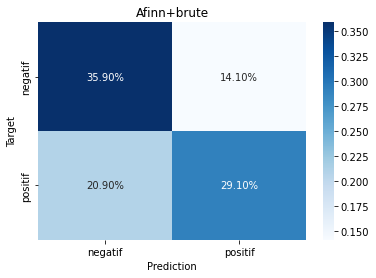

Score f1 0.6244635193133048
Score acc 0.65


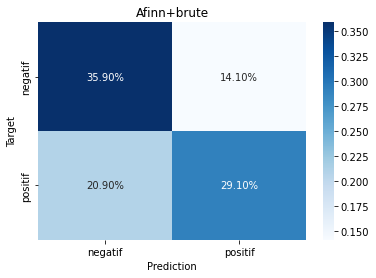

Score f1 0.6214442013129102
Score acc 0.654


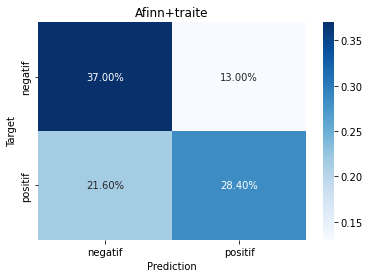

Score f1 0.6214442013129102
Score acc 0.654


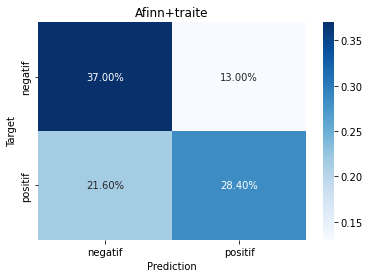

Score f1 0.5542725173210162
Score acc 0.614


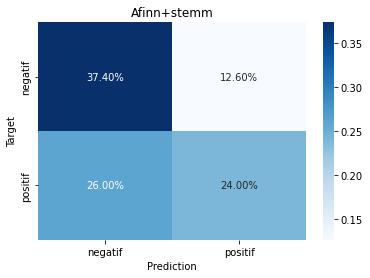

Score f1 0.5542725173210162
Score acc 0.614


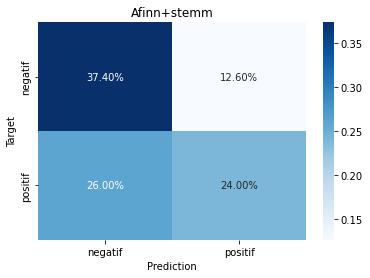

Score f1 0.6232356134636264
Score acc 0.653


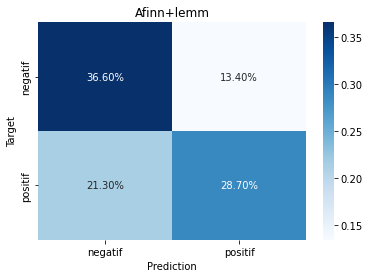

Score f1 0.6232356134636264
Score acc 0.653


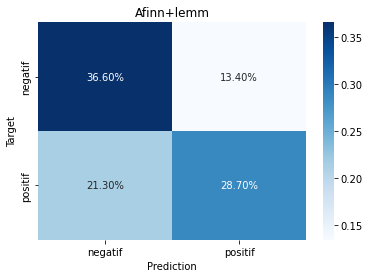

In [21]:
dict_score_afinn = {}
for i in liste_prediction_type_afinn:
    score_f1, score_acc = matrice_confusion(df_sample_afinn, i)
    dict_score_afinn[i] = [score_f1, score_acc]
    matrice_confusion(df_sample_afinn, i)

# Range le dictionnaire dans l'ordre croisant (sur les valeurs)
dict_score_afinn = dict(
    sorted(dict_score_afinn.items(), key=lambda item: item[1]))

In [46]:
dict_score_afinn

{'Afinn+stemm': [0.5542725173210162, 0.614],
 'Afinn+traite': [0.6214442013129102, 0.654],
 'Afinn+lemm': [0.6232356134636264, 0.653],
 'Afinn+brute': [0.6244635193133048, 0.65]}

Le modèle de prédiction avec **Afinn** donne un score plus élevé.

Il est intéressant de voir que pour nos deux modèles, ce sont les tweets bruts sans aucun nettoyage qui ont permis à nos modèles de prédire les sentiments.

Voyons maintenant ce que nous pouvons obtenir avec un modèle assez basique entrainé par nous même.

## Régression logistique

Commençons à entrainer notre modèle.

Importons nos données.

In [24]:
# Nous allons récupérer un sample de notre dataframe
row = 1500

# Permets de garder un équilibrage de la target contrairement à un
# .sample() basique
df_sample = df.groupby('sentiment').apply(
    lambda x: x.sample(n=row, random_state=42))
df_sample.reset_index(drop=True, inplace=True)

In [25]:
print(df_sample.shape)
print(df_sample.sentiment.value_counts())
df_sample.head()

(3000, 5)
0    1500
1    1500
Name: sentiment, dtype: int64


,sentiment,tweet,tweet_traite,tweet_stemm,tweet_lemm
0,0,"@LeahMul awh, thats not good, get better soon!",user awh that is not good get better soon,user awh that is not good get better soon,user awh that be not good get well soon
1,0,I need a job,need job,need job,need job
2,0,i am pretty sure i have swine flu woohooo one...,am pretty sure have swine flu woohooo one tes...,am pretti sure have swine flu woohooo one tes...,be pretty sure have swine flu woohooo one tes...
3,0,GLG will never EVER be the same,glg will never ever be the same,glg will never ever be the same,glg will never ever be the same
4,0,Enjoying my last days w/ my 1 year old Where ...,enjoying my last days my year old where does t...,enjoy my last day my year old where doe the fr...,enjoy my last day my year old where do the frk...


In [26]:
df_modele = df_sample.copy()
# Nous stockerons dans ce dictionnaire les scores obtenus pour chaque
# type de nettoyage de tweet
dict_type_tweet = {}

In [27]:
# Sépare les données afin d'obtenir 90% de données pour l'entrainement
# et 10% pour les tests
X = df_modele.tweet
y = df_modele.sentiment
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=26105111)

Nous allons maintenant vectoriser nos tweets avec TfidfVectorizer.

In [28]:
vectoriser = TfidfVectorizer(ngram_range=(1, 2))
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  30620


/home/reda/anaconda3/envs/P7/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [29]:
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

Notre modèle est maintenant entrainé, voyons voir les résultats.

In [30]:
LRmodel = LogisticRegression(C=2, n_jobs=4)
LRmodel.fit(X_train, y_train)

# Prédis les valeurs de l'ensemble de données de test
y_pred = LRmodel.predict(X_test)

0.7189542483660132 0.7133333333333334


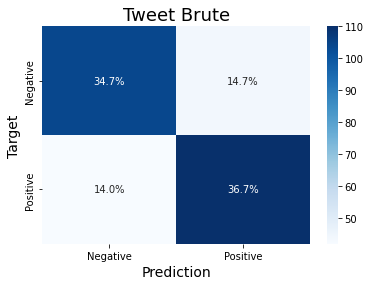

In [31]:
# Calculer et tracer la matrice de confusion
cf_matrix = confusion_matrix(y_test, y_pred)
categories = ['Negative', 'Positive']

# Convertis les prédictions en pourcentages
percentages = [
    '{0:.1%}'.format(value)
    for value in cf_matrix.flatten() / np.sum(cf_matrix)
]

labels = [f'{percent}' for percent in percentages]
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(cf_matrix,
            annot=labels,
            cmap='Blues',
            fmt='',
            xticklabels=categories,
            yticklabels=categories)

plt.xlabel("Prediction", fontdict={'size': 14})
plt.ylabel("Target", fontdict={'size': 14})
plt.title("Tweet Brute", fontdict={'size': 18})
print(f1_score(y_test, y_pred), accuracy_score(y_test, y_pred))

In [32]:
# Nous stockons le score dans notre dictionnaire
dict_type_tweet["LR+tweet_brute"] = [
    f1_score(y_test, y_pred),
    accuracy_score(y_test, y_pred)
]

Nous allons maintenant créer deux fonctions pour facilement entrainer et obtenir nos résultats sur les prochains modèles.

In [33]:
def model(type_tweet):

    X = df_modele[type_tweet]
    y = df_modele.sentiment
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    vectoriser = TfidfVectorizer(ngram_range=(1, 2))
    vectoriser.fit(X_train)

    X_train = vectoriser.transform(X_train)
    X_test = vectoriser.transform(X_test)

    LRmodel = LogisticRegression(C=2, max_iter=1000, n_jobs=-1)
    LRmodel.fit(X_train, y_train)

    # Prédis les valeurs de l'ensemble de données de test
    y_pred = LRmodel.predict(X_test)

    # Calculer et tracer la matrice de confusion
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']

    # Convertis les prédictions en pourcentages
    percentages = [
        '{0:.1%}'.format(value)
        for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]

    labels = [f'{percent}' for percent in percentages]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix,
                annot=labels,
                cmap='Blues',
                fmt='',
                xticklabels=categories,
                yticklabels=categories)

    plt.xlabel("Prediction", fontdict={'size': 14})
    plt.ylabel("Target", fontdict={'size': 14})
    plt.title(type_tweet, fontdict={'size': 18})
    plt.show()
    return f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

In [34]:
liste_prediction_type_model = ["tweet_traite", "tweet_stemm", "tweet_lemm"]

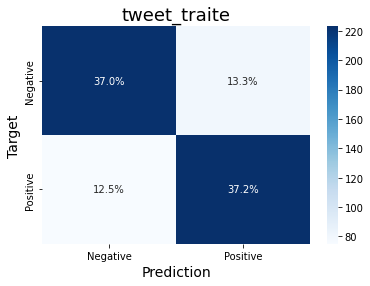

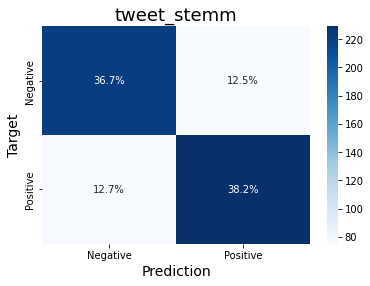

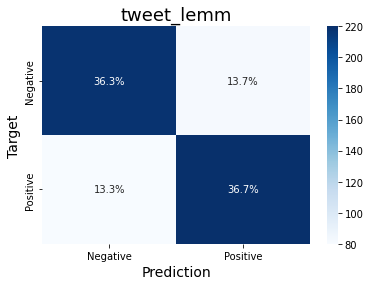

In [35]:
for i in liste_prediction_type_model:
    score_f1, score_acc = model(i)
    dict_type_tweet["LR+" + i] = [score_f1, score_acc]

In [42]:
liste_dicte = [dict_type_tweet, dict_score_afinn, dict_score_txtblob]
df_classement_model = pd.DataFrame(columns=['model', 'f1_score', 'accuracy'])

for dicte in liste_dicte:
    for key, values in dicte.items():
        df_classement_model = df_classement_model.append(
            {
                'model': key,
                'f1_score': values[0],
                'accuracy': values[1]
            },
            ignore_index=True)

/tmp/ipykernel_961/3055109459.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_classement_model = df_classement_model.append(
/tmp/ipykernel_961/3055109459.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_classement_model = df_classement_model.append(
/tmp/ipykernel_961/3055109459.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_classement_model = df_classement_model.append(
/tmp/ipykernel_961/3055109459.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_classement_model = df_classement_model.append(
/tmp/ipykernel_961/3055109459.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pa

In [43]:
df_classement_model

,model,f1_score,accuracy
0,LR+tweet_brute,0.718954,0.713333
1,LR+tweet_lemm,0.730897,0.730000
2,LR+tweet_traite,0.742097,0.741667
3,LR+tweet_stemm,0.752053,0.748333
4,Afinn+stemm,0.554273,0.614000
5,Afinn+traite,0.621444,0.654000
6,Afinn+lemm,0.623236,0.653000
7,Afinn+brute,0.624464,0.650000
8,TextBlob+stemm,0.496437,0.576000
9,TextBlob+lemm,0.570175,0.608000


<AxesSubplot:ylabel='model'>

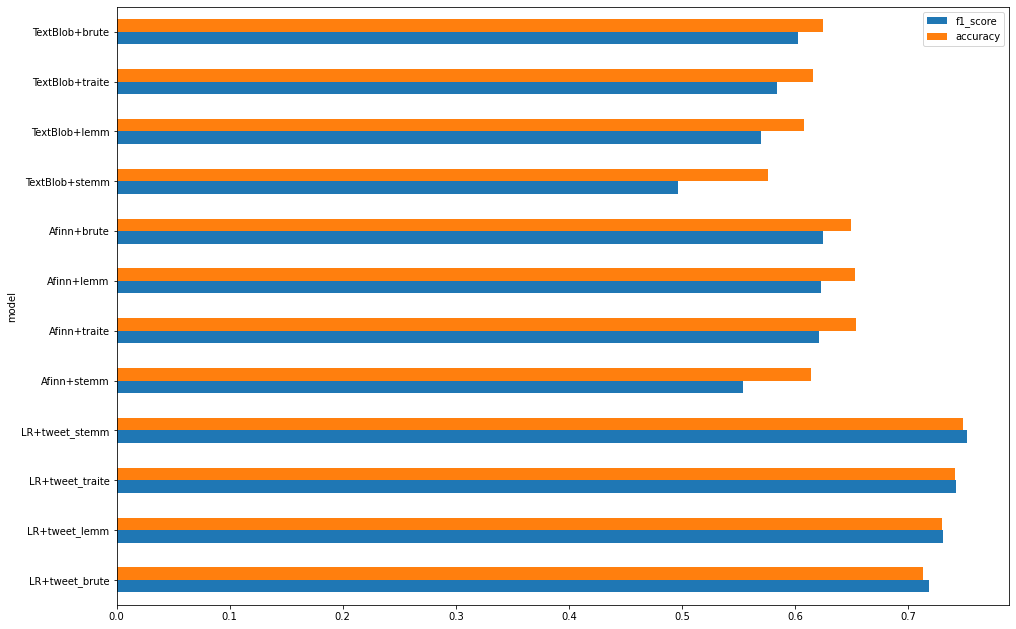

In [44]:
df_classement_model.plot.barh(x='model', figsize=(16, 11))

Pour le modèle que nous avons entrainé, de manière assez simple, nous avons obtenu un score de ~75% qui est bien supérieur aux modèles préentrainés.

Nous pouvons remarquer également deux choses, le modèle a eu les meilleures prédictions en s'entrainant avec les tweets racinisés.
La deuxième remarque est que cette fois-ci, les tweets bruts se retrouvent en bas du classement.

Nous avons effectué une série de tests avec des modèles préentrainés et un modèle entrainé par nous même avec des résultats intéressants.

Voyons maintenant ce que nous pouvons obtenir comme résultat avec un modèle avancé dans le notebook suivant.